# 1. Defining Problem

In [ ]:
# #set a working directory on the google drive
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/Colab Notebooks/dc-workshop/

In [ ]:
#pip install rioxarray scikit-plot rasterio

In [11]:
#Load the libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import rioxarray as rxr
import rasterio
from rasterio.plot import plotting_extent
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
import rasterio



# #Import machine learning libraries
import scikitplot as skplt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import  GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder



In [ ]:
#load the dataset
src=rasterio.open("S2_srw.tif")
train_points=gpd.read_file("rwanda_points_new.shp")

In [3]:
# read all bands of the dataset into 3-dimensional array stack - (band, row, column)
stack = src.read() 
print(stack.shape)

(11, 881, 654)


In [9]:
img = src.read()   # load our original input file bands to a numby array stack
profile = src.profile  # the copy the profile of the original GeoTIFF input file
with rasterio.io.MemoryFile() as memfile:
    with memfile.open(**profile) as dst:
        for i in range(0, src.count):
            dst.write(img[i], i+1)
    dataset = memfile.open()

In [ ]:
train_points.head()

In [ ]:

fig, ax=plt.subplots(figsize=[15,15])
train_points.plot(color='None',
                    edgecolor='blue',
                    linewidth=2, ax=ax
                    )

plt.show();

In [41]:
#check that the reference coordinates are the same for all dataset
print(sentinel2.rio.crs)
print(train_points.crs)

EPSG:4326
EPSG:4326


In [112]:
src.read()

array([[[0.1743, 0.1743, 0.1928, ..., 0.2264, 0.2003, 0.2003],
        [0.1876, 0.1876, 0.203 , ..., 0.2264, 0.2003, 0.2003],
        [0.1876, 0.1876, 0.203 , ..., 0.2395, 0.2019, 0.2019],
        ...,
        [0.1841, 0.1659, 0.1659, ..., 0.1286, 0.1286, 0.1364],
        [0.1925, 0.1835, 0.1835, ..., 0.1286, 0.1286, 0.1364],
        [0.1925, 0.1835, 0.1835, ..., 0.1343, 0.1343, 0.1323]],

       [[0.2543, 0.2543, 0.2613, ..., 0.3114, 0.2852, 0.2852],
        [0.2569, 0.2569, 0.2619, ..., 0.3114, 0.2852, 0.2852],
        [0.2569, 0.2569, 0.2619, ..., 0.325 , 0.2842, 0.2842],
        ...,
        [0.2861, 0.2682, 0.2682, ..., 0.172 , 0.172 , 0.1835],
        [0.2945, 0.2833, 0.2833, ..., 0.172 , 0.172 , 0.1835],
        [0.2945, 0.2833, 0.2833, ..., 0.1829, 0.1829, 0.1773]],

       [[0.1011, 0.1011, 0.1011, ..., 0.1011, 0.1012, 0.1012],
        [0.1011, 0.1011, 0.1011, ..., 0.1011, 0.1012, 0.1012],
        [0.1011, 0.1011, 0.1011, ..., 0.1011, 0.1011, 0.1011],
        ...,
        [0.1

In [ ]:
#titles=['red', 'green', 'near\ninfrared']
sentinel2=rxr.open_rasterio("/home/drdc/Documents/repos/Portfolio/dc-workshop/orginal/S2_srw.tif", masked=True).squeeze()
ep.plot_bands(sentinel2,cmap="viridis",
              figsize=[10,8],
              title="")
plt.show()

In [ ]:
# overlay data on sentinel image

sentinel_plot_extent = plotting_extent(sentinel2[0], 
                                   sentinel2.rio.transform())
f, ax = plt.subplots(figsize=[15,15])

ep.plot_rgb(sentinel2.values,
            rgb=[0, 4, 8],
            ax=ax,
            title="Sampling points overlayed on top of Sentinel 2 data",
            extent=sentinel_plot_extent)  # Use plotting extent from DatasetReader object

train_points.plot(ax=ax, color="blue", edgecolor="blue")

plt.show()

In [ ]:
#titles=['red', 'green', 'near\ninfrared']
sentinel2["NDVI"]=(sentinel2[8]-sentinel2[4])/(sentinel2[8]+sentinel2[4])
ep.plot_bands(sentinel2["NDVI"],cmap="RdYlGn_r",
              figsize=[10,8],
              title="")
plt.show()

In [10]:
#get the index of the training points
train_points.index= range(len(train_points))

In [142]:
coords = [(x,y) for x, y in zip(train_points.geometry.x, train_points.geometry.y)]  # Create list of point coordinates
coords[0:5]

[(29.05868427375566, -2.4251230961172885),
 (29.061584078857702, -2.4288439506871766),
 (29.062051082353786, -2.4294390851063747),
 (29.06231998869901, -2.4308400955946285),
 (29.06508154727875, -2.4320151910342345)]

In [143]:
src.descriptions

('B12', 'B11', 'B10', 'B9', 'B8', 'B7', 'B6', 'B5', 'B4', 'B3', 'B2')

In [144]:
bands= list(src.descriptions)      # Read all bands together
bands

['B12', 'B11', 'B10', 'B9', 'B8', 'B7', 'B6', 'B5', 'B4', 'B3', 'B2']

In [145]:
#Sample the each band of raster dataset at each point in the coordinate list
train_points['raster_value'] = [x for x in dataset.sample(coords)]   # all band values are saved as a list in the Raster Value column 
train_points.head()

,category,geometry,B12,B11,B10,B9,B8,B7,B6,B5,B4,B3,B2,raster_value
0,forest,POINT (29.05868 -2.42512),0.1601,0.2375,0.1011,0.1641,0.3235,0.3295,0.2809,0.1820,0.1574,0.1754,0.1921,"[0.1601, 0.2375, 0.1011, 0.1641, 0.3235, 0.329..."
1,tea,POINT (29.06158 -2.42884),0.1669,0.2689,0.1011,0.1912,0.4362,0.4444,0.3682,0.2084,0.1557,0.1918,0.1945,"[0.1669, 0.2689, 0.1011, 0.1912, 0.4362, 0.444..."
2,tea,POINT (29.06205 -2.42944),0.1992,0.2977,0.1011,0.1783,0.3951,0.4032,0.3442,0.1986,0.1654,0.1853,0.1955,"[0.1992, 0.2977, 0.1011, 0.1783, 0.3951, 0.403..."
3,tea,POINT (29.06232 -2.43084),0.1590,0.2605,0.1011,0.2002,0.4599,0.4679,0.3836,0.2054,0.1556,0.1934,0.1932,"[0.159, 0.2605, 0.1011, 0.2002, 0.4599, 0.4679..."
4,tea,POINT (29.06508 -2.43202),0.1599,0.2598,0.1011,0.1958,0.4520,0.4589,0.3820,0.2033,0.1546,0.1904,0.1938,"[0.1599, 0.2598, 0.1011, 0.1958, 0.452, 0.4589..."


In [146]:
# Unpack the Raster Value column to separate column for each band - band names were retrieved with snappy and are now usef as column names
train_points[bands] = pd.DataFrame(train_points['raster_value'].tolist(), index= train_points.index)  
train_points = train_points.drop(['raster_value'], axis=1)  # Remove Raster Value column

In [147]:
train_points.head()

,category,geometry,B12,B11,B10,B9,B8,B7,B6,B5,B4,B3,B2
0,forest,POINT (29.05868 -2.42512),0.1601,0.2375,0.1011,0.1641,0.3235,0.3295,0.2809,0.1820,0.1574,0.1754,0.1921
1,tea,POINT (29.06158 -2.42884),0.1669,0.2689,0.1011,0.1912,0.4362,0.4444,0.3682,0.2084,0.1557,0.1918,0.1945
2,tea,POINT (29.06205 -2.42944),0.1992,0.2977,0.1011,0.1783,0.3951,0.4032,0.3442,0.1986,0.1654,0.1853,0.1955
3,tea,POINT (29.06232 -2.43084),0.1590,0.2605,0.1011,0.2002,0.4599,0.4679,0.3836,0.2054,0.1556,0.1934,0.1932
4,tea,POINT (29.06508 -2.43202),0.1599,0.2598,0.1011,0.1958,0.4520,0.4589,0.3820,0.2033,0.1546,0.1904,0.1938


In [148]:
# extract x and y coodinates
train_points["x"]=train_points.geometry.x
train_points["y"]=train_points.geometry.y
train_points=train_points.drop(columns="geometry")
#look at the head once again
train_points.head()

,category,B12,B11,B10,B9,B8,B7,B6,B5,B4,B3,B2,x,y
0,forest,0.1601,0.2375,0.1011,0.1641,0.3235,0.3295,0.2809,0.1820,0.1574,0.1754,0.1921,29.058684,-2.425123
1,tea,0.1669,0.2689,0.1011,0.1912,0.4362,0.4444,0.3682,0.2084,0.1557,0.1918,0.1945,29.061584,-2.428844
2,tea,0.1992,0.2977,0.1011,0.1783,0.3951,0.4032,0.3442,0.1986,0.1654,0.1853,0.1955,29.062051,-2.429439
3,tea,0.1590,0.2605,0.1011,0.2002,0.4599,0.4679,0.3836,0.2054,0.1556,0.1934,0.1932,29.062320,-2.430840
4,tea,0.1599,0.2598,0.1011,0.1958,0.4520,0.4589,0.3820,0.2033,0.1546,0.1904,0.1938,29.065082,-2.432015


In [149]:
#create a copy of the data to avoid modification of orginal data
df_clean=train_points.copy()

In [150]:
#look at the header of the cleaned data
df_clean.head()

,category,B12,B11,B10,B9,B8,B7,B6,B5,B4,B3,B2,x,y
0,forest,0.1601,0.2375,0.1011,0.1641,0.3235,0.3295,0.2809,0.1820,0.1574,0.1754,0.1921,29.058684,-2.425123
1,tea,0.1669,0.2689,0.1011,0.1912,0.4362,0.4444,0.3682,0.2084,0.1557,0.1918,0.1945,29.061584,-2.428844
2,tea,0.1992,0.2977,0.1011,0.1783,0.3951,0.4032,0.3442,0.1986,0.1654,0.1853,0.1955,29.062051,-2.429439
3,tea,0.1590,0.2605,0.1011,0.2002,0.4599,0.4679,0.3836,0.2054,0.1556,0.1934,0.1932,29.062320,-2.430840
4,tea,0.1599,0.2598,0.1011,0.1958,0.4520,0.4589,0.3820,0.2033,0.1546,0.1904,0.1938,29.065082,-2.432015


In [151]:
# Give the categorical colum a meaningfull name 
df_clean.rename(columns={"category":"class"},inplace=True)

df_clean.head()

,class,B12,B11,B10,B9,B8,B7,B6,B5,B4,B3,B2,x,y
0,forest,0.1601,0.2375,0.1011,0.1641,0.3235,0.3295,0.2809,0.1820,0.1574,0.1754,0.1921,29.058684,-2.425123
1,tea,0.1669,0.2689,0.1011,0.1912,0.4362,0.4444,0.3682,0.2084,0.1557,0.1918,0.1945,29.061584,-2.428844
2,tea,0.1992,0.2977,0.1011,0.1783,0.3951,0.4032,0.3442,0.1986,0.1654,0.1853,0.1955,29.062051,-2.429439
3,tea,0.1590,0.2605,0.1011,0.2002,0.4599,0.4679,0.3836,0.2054,0.1556,0.1934,0.1932,29.062320,-2.430840
4,tea,0.1599,0.2598,0.1011,0.1958,0.4520,0.4589,0.3820,0.2033,0.1546,0.1904,0.1938,29.065082,-2.432015


In [152]:
# replace categorical data with numerical data for easy computation 
df_clean=df_clean.replace({"water":1, "forest":2, "tea":3, "other":4})
df_clean.head()

,class,B12,B11,B10,B9,B8,B7,B6,B5,B4,B3,B2,x,y
0,2,0.1601,0.2375,0.1011,0.1641,0.3235,0.3295,0.2809,0.1820,0.1574,0.1754,0.1921,29.058684,-2.425123
1,3,0.1669,0.2689,0.1011,0.1912,0.4362,0.4444,0.3682,0.2084,0.1557,0.1918,0.1945,29.061584,-2.428844
2,3,0.1992,0.2977,0.1011,0.1783,0.3951,0.4032,0.3442,0.1986,0.1654,0.1853,0.1955,29.062051,-2.429439
3,3,0.1590,0.2605,0.1011,0.2002,0.4599,0.4679,0.3836,0.2054,0.1556,0.1934,0.1932,29.062320,-2.430840
4,3,0.1599,0.2598,0.1011,0.1958,0.4520,0.4589,0.3820,0.2033,0.1546,0.1904,0.1938,29.065082,-2.432015


In [ ]:
# #Create arrays for model development
# array=df_clean.values
# x=array[:,1:12]
# y=array[:,0].astype(int)


# # verify values
# print(x[0:15])
# print(y[0:5])

In [153]:
#use the dataframe for modeling instead of numpy array

#Create arrays for model development

x=df_clean.iloc[:,1:14]
y=df_clean.iloc[:,0]

In [24]:
#check predictors
x.head()

,B12,B11,B10,B9,B8,B7,B6,B5,B4,B3,B2,x,y
0,0.1601,0.2375,0.1011,0.1641,0.3235,0.3295,0.2809,0.1820,0.1574,0.1754,0.1921,29.058684,-2.425123
1,0.1669,0.2689,0.1011,0.1912,0.4362,0.4444,0.3682,0.2084,0.1557,0.1918,0.1945,29.061584,-2.428844
2,0.1992,0.2977,0.1011,0.1783,0.3951,0.4032,0.3442,0.1986,0.1654,0.1853,0.1955,29.062051,-2.429439
3,0.1590,0.2605,0.1011,0.2002,0.4599,0.4679,0.3836,0.2054,0.1556,0.1934,0.1932,29.062320,-2.430840
4,0.1599,0.2598,0.1011,0.1958,0.4520,0.4589,0.3820,0.2033,0.1546,0.1904,0.1938,29.065082,-2.432015


In [22]:
#check target variable or land cover classes
y.head()

0    2
1    3
2    3
3    3
4    3
Name: class, dtype: int64

In [154]:
#create a validation set to evaluate the model
#Evaluate Algorithms: Baseline
# Test options and evaluation metric
num_folds=10
seed=7
scoring='accuracy'
val_size=0.20
seed=7
x_train, x_val, y_train,y_val=train_test_split(x,y,test_size=val_size, random_state=seed)

In [156]:
# ensembles
scoring='accuracy'
ensembles=[]
#ensembles.append(('LR', LogisticRegression()))
ensembles.append(('AB',AdaBoostClassifier()))
ensembles.append(('GBM',GradientBoostingClassifier()))
ensembles.append(('RF',RandomForestClassifier()))
ensembles.append(('ET',ExtraTreesClassifier()))

results_ens=[]
names_ens=[]
for name, model in ensembles:
    kfold=KFold(n_splits=num_folds, random_state=seed,shuffle=True)
    cv_results=cross_val_score(model,x_train,y_train,cv=kfold, scoring=scoring,n_jobs=14)
    results_ens.append(cv_results)
    names_ens.append(name)
    print(name,'=', round(cv_results.mean(),2),'±',round(cv_results.std(),2))

AB = 0.83 ± 0.05
GBM = 0.94 ± 0.02
RF = 0.93 ± 0.03
ET = 0.94 ± 0.02


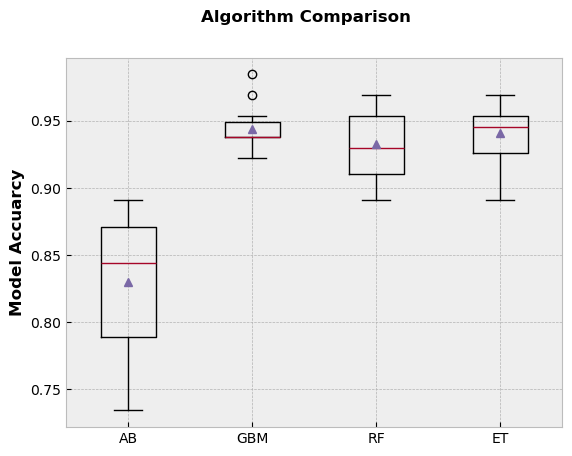

In [157]:
# d) Compare Algorithms
plt.style.use("bmh")
fig=plt.figure()
fig.suptitle('Algorithm Comparison',size=12, weight="bold")
ax = fig.add_subplot(111)
plt.boxplot(results_ens,labels=names_ens, showmeans=True)
ax.set_xticklabels(names_ens)
plt.ylabel("Model Accuarcy",size=12, weight="bold")
plt.show()

In [161]:
#Tune the best model RF
param_grid = dict(n_estimators=np.array([50,100,150,200,250,300,350,400]))
    # max_depth = np.array([80, 90, 100, 110]),
    # min_samples_leaf = np.array([1, 2, 3, 4, 5]),
    # min_samples_split = np.array([2, 4, 8, 10]),
    # bootstrap = [True, False])
    
model = ExtraTreesClassifier(random_state=seed, n_jobs=14)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(x_train, y_train)
print("Best: %f using %s" % (round(grid_result.best_score_,2), grid_result.best_params_))

Best: 0.940000 using {'n_estimators': 250}


In [162]:
#Finalize the model
final_ET=ExtraTreesClassifier(random_state=seed, n_estimators=250)
classifier=final_ET.fit(x_train, y_train)

# Make predictions on validation dataset

predictions= classifier.predict(x_val)
print(accuracy_score(y_val, predictions))

0.925


In [163]:
#print the confusion matrix
print(confusion_matrix(y_val, predictions))

[[39  0  0  1]
 [ 0 29  2  0]
 [ 0  1 40  4]
 [ 0  1  3 40]]


In [164]:
#now let's print the classification report
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           1       1.00      0.97      0.99        40
           2       0.94      0.94      0.94        31
           3       0.89      0.89      0.89        45
           4       0.89      0.91      0.90        44

    accuracy                           0.93       160
   macro avg       0.93      0.93      0.93       160
weighted avg       0.93      0.93      0.93       160



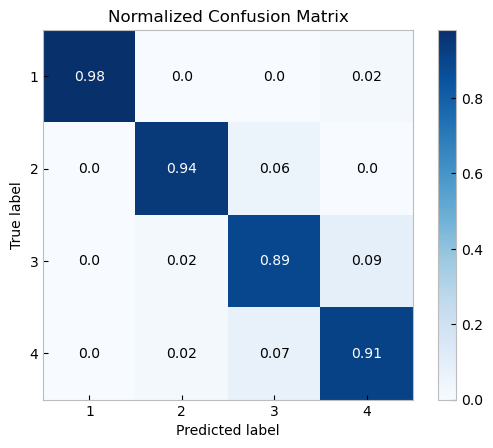

In [165]:
#we can now use the scikitplot to visualize the report
skplt.metrics.plot_confusion_matrix(y_val, predictions, normalize=True)
plt.show()

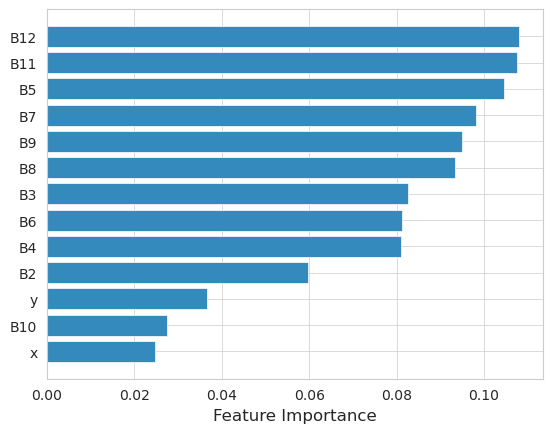

In [166]:
#plot variables importance
# get importance from Random Forest
sns.set_style("whitegrid")
importance = classifier.feature_importances_

variables=list(x.columns)
variables
feature=x_train.columns
sorted_idx = classifier.feature_importances_.argsort()
plt.barh(feature[sorted_idx], classifier.feature_importances_[sorted_idx])
plt.xlabel("Feature Importance");


In [140]:
import rasterio
import pandas as pd
import numpy as np

def raster_geotiff_to_dataframe(geotiff_file):
    try:
        # Open the raster GeoTIFF file
        with rasterio.open(geotiff_file) as src:
            # Read all bands into a numpy array (bands are indexed from 1 to n)
            bands_data = [src.read(band_num) for band_num in range(1, src.count + 1)]
            bands_data = [band.squeeze() for band in bands_data]

            # Get the geospatial transformation (affine) parameters
            transform = src.transform

            # Create a meshgrid for pixel coordinates
            rows, cols = src.shape
            x, y = np.meshgrid(np.arange(cols) + 0.5, np.arange(rows) + 0.5)
            x, y = rasterio.transform.xy(transform, y.flatten(), x.flatten())

            # Create a DataFrame with the pixel coordinates and each band's data
            df = pd.DataFrame({'X': x, 'Y': y})
            for band_num, band_data in enumerate(bands_data, start=1):
                df[f'Band_{band_num}'] = band_data.flatten()

            return df

    except Exception as e:
        print(f"Error: {e}")
        return None


# load th whole sentinel image

geotiff_file_path = "/home/drdc/Documents/repos/Portfolio/dc-workshop/orginal/S2_srw.tif"
df = raster_geotiff_to_dataframe(geotiff_file_path)
df.head()

,X,Y,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_9,Band_10,Band_11
0,29.026723,-2.397065,0.1743,0.2543,0.1011,0.1786,0.3251,0.3460,0.3085,0.2010,0.1622,0.1809,0.1985
1,29.026813,-2.397065,0.1743,0.2543,0.1011,0.1786,0.3330,0.3460,0.3085,0.2010,0.1702,0.1890,0.1999
2,29.026902,-2.397065,0.1928,0.2613,0.1011,0.1786,0.3044,0.3286,0.2948,0.2109,0.1871,0.1909,0.2010
3,29.026992,-2.397065,0.1928,0.2613,0.1011,0.1786,0.2935,0.3286,0.2948,0.2109,0.1953,0.1919,0.2036
4,29.027082,-2.397065,0.1783,0.2541,0.1012,0.1723,0.3059,0.3176,0.2865,0.1966,0.1825,0.1913,0.2021


In [141]:
#rename the columns to match the training data

df.rename(columns={"Y":"y","X":"x",
                   "Band_1":"B12",
                              "Band_2":"B11",
                              	"Band_3":"B10",
                                    "Band_4":"B9",
                                    "Band_5":"B8",
                                    "Band_6":"B7",
                                    "Band_7":"B6",
                                    "Band_8":"B5",
                                    "Band_9":"B4",
                                    "Band_10":"B3",
                                    "Band_11":"B2"}, inplace=True)


df.head()

,x,y,B12,B11,B10,B9,B8,B7,B6,B5,B4,B3,B2
0,29.026723,-2.397065,0.1743,0.2543,0.1011,0.1786,0.3251,0.3460,0.3085,0.2010,0.1622,0.1809,0.1985
1,29.026813,-2.397065,0.1743,0.2543,0.1011,0.1786,0.3330,0.3460,0.3085,0.2010,0.1702,0.1890,0.1999
2,29.026902,-2.397065,0.1928,0.2613,0.1011,0.1786,0.3044,0.3286,0.2948,0.2109,0.1871,0.1909,0.2010
3,29.026992,-2.397065,0.1928,0.2613,0.1011,0.1786,0.2935,0.3286,0.2948,0.2109,0.1953,0.1919,0.2036
4,29.027082,-2.397065,0.1783,0.2541,0.1012,0.1723,0.3059,0.3176,0.2865,0.1966,0.1825,0.1913,0.2021


In [48]:
#check the order of the training data 
x_train.columns

#It looks like the order of the training data is different from the ones of satelite data
# We will need to reorder the environmental covariates/satellite data before final prediction

Index(['B12', 'B11', 'B10', 'B9', 'B8', 'B7', 'B6', 'B5', 'B4', 'B3', 'B2',
       'x', 'y'],
      dtype='object')

In [167]:
#reorder the column to fit the training data
df_S2=df[['B12', 'B11', 'B10', 'B9', 'B8', 'B7', 'B6', 'B5', 'B4', 'B3', 'B2',
       'x', 'y']]
df_S2.head()

,B12,B11,B10,B9,B8,B7,B6,B5,B4,B3,B2,x,y
0,0.1743,0.2543,0.1011,0.1786,0.3251,0.3460,0.3085,0.2010,0.1622,0.1809,0.1985,29.026723,-2.397065
1,0.1743,0.2543,0.1011,0.1786,0.3330,0.3460,0.3085,0.2010,0.1702,0.1890,0.1999,29.026813,-2.397065
2,0.1928,0.2613,0.1011,0.1786,0.3044,0.3286,0.2948,0.2109,0.1871,0.1909,0.2010,29.026902,-2.397065
3,0.1928,0.2613,0.1011,0.1786,0.2935,0.3286,0.2948,0.2109,0.1953,0.1919,0.2036,29.026992,-2.397065
4,0.1783,0.2541,0.1012,0.1723,0.3059,0.3176,0.2865,0.1966,0.1825,0.1913,0.2021,29.027082,-2.397065


In [168]:
# Make predictions on complete dataset

predictions_all= classifier.predict(df_S2)
#reshape the data to fit the raster size
predict_np=predictions_all.reshape(881,654)

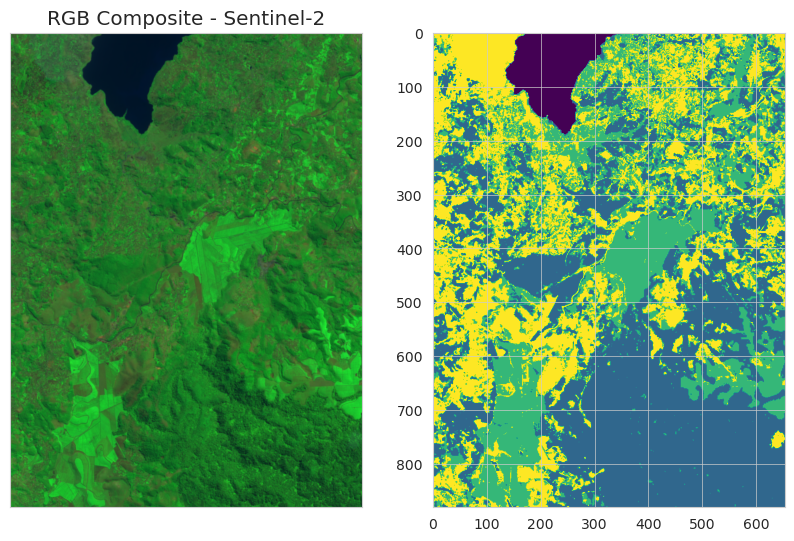

In [170]:
# Plot the landcover map
import rasterio as rio
df_im=rio.open('/home/drdc/Documents/repos/Portfolio/dc-workshop/orginal/S2_srw.tif')
values=df_im.read()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

ep.plot_rgb(values,
            rgb=[0,4,9], ax=ax1,title="RGB Composite - Sentinel-2")

ax2=ax2.imshow(predict_np, cmap="viridis")

plt.show();

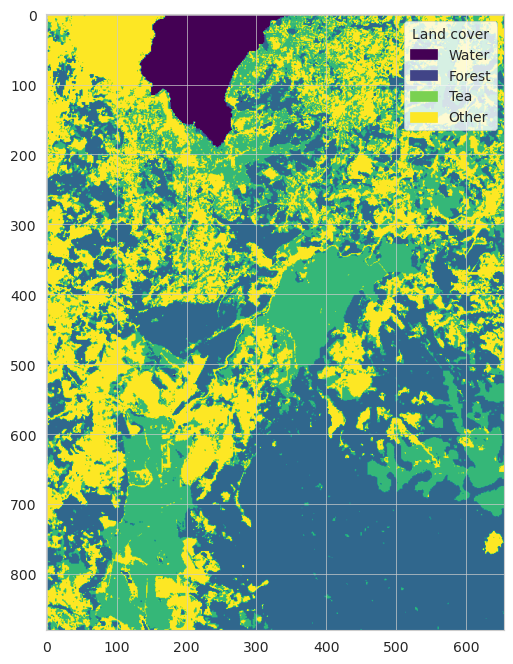

In [189]:
fig, ax = plt.subplots(figsize=(10, 8))

# Display the image
plt.imshow(predict_np, cmap='viridis')  # You can choose a different colormap if needed

# Create a legend for categories
category_labels = ["Water", "Forest", "Tea", "Other"]  
category_colors = ['#440154FF', '#414487FF', '#7AD151FF',"#FDE725FF"]  

# Create proxy artists (patches) for legend
legend_patches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in category_colors]

# Add the legend
plt.legend(legend_patches, category_labels, loc='upper right', title='Land cover')

# Show the plot
plt.show()